In [1]:
import os
import cv2
import itertools
import numpy as np
import splitfolders
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.applications.vgg19 import VGG19
from keras.layers import Input, Lambda, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator

In [2]:
if not os.path.exists(os.path.join(os.getcwd(), 'output')):
    splitfolders.ratio("indoorCVPR_09/Images", output="output", seed=1337, ratio=(.7, .2, .1), group_prefix=None)

In [3]:
folders = glob('indoorCVPR_09/Images/*')
categories = [folder.split("\\")[-1] for folder in folders]

categories[:5]

['airport_inside', 'artstudio', 'auditorium', 'bakery', 'bar']

In [4]:
labels = {}
label_no = 0
for category in categories:
    labels[label_no] = category
    label_no += 1

dict(itertools.islice(labels.items(), 10))

{0: 'airport_inside',
 1: 'artstudio',
 2: 'auditorium',
 3: 'bakery',
 4: 'bar',
 5: 'bathroom',
 6: 'bedroom',
 7: 'bookstore',
 8: 'bowling',
 9: 'buffet'}

In [5]:
vgg19 = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
vgg19.trainable = False

In [6]:
flatten_layer = Flatten()
prediction_layer = Dense(len(folders), activation='softmax')

model = Sequential([
    vgg19,
    flatten_layer,
    prediction_layer
])

# view the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 67)                1680963   
Total params: 21,705,347
Trainable params: 1,680,963
Non-trainable params: 20,024,384
_________________________________________________________________


In [7]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

training_set = train_datagen.flow_from_directory(
    'output/train/',
     target_size=(224, 224),
     batch_size=32,
     class_mode='categorical'
)

validation_set = val_datagen.flow_from_directory(
    'output/val/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 10903 images belonging to 67 classes.
Found 3098 images belonging to 67 classes.


In [9]:
model.fit(
    training_set,
    validation_data=validation_set,
    epochs=10,
    batch_size=32,
)

Epoch 1/10
341/341 [==============================] - 458s 1s/step - loss: 3.3811 - accuracy: 0.3068 - val_loss: 2.7831 - val_accuracy: 0.4145
Epoch 2/10
341/341 [==============================] - 360s 1s/step - loss: 2.0984 - accuracy: 0.5133 - val_loss: 2.6964 - val_accuracy: 0.4493
Epoch 3/10
341/341 [==============================] - 228s 665ms/step - loss: 1.6385 - accuracy: 0.6041 - val_loss: 2.4620 - val_accuracy: 0.4948
Epoch 4/10
341/341 [==============================] - 210s 617ms/step - loss: 1.3892 - accuracy: 0.6579 - val_loss: 2.8710 - val_accuracy: 0.4645
Epoch 5/10
341/341 [==============================] - 157s 460ms/step - loss: 1.1082 - accuracy: 0.7118 - val_loss: 2.8226 - val_accuracy: 0.5029
Epoch 6/10
341/341 [==============================] - 158s 464ms/step - loss: 0.9651 - accuracy: 0.7429 - val_loss: 2.6044 - val_accuracy: 0.5132
Epoch 7/10
341/341 [==============================] - 160s 470ms/step - loss: 0.8942 - accuracy: 0.7636 - val_loss: 2.7892 - val_a

In [10]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_set = test_datagen.flow_from_directory(
    'output/test/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1619 images belonging to 67 classes.


In [11]:
model.evaluate(test_set)

51/51 [==============================] - 44s 869ms/step - loss: 3.1282 - accuracy: 0.4954


[3.128175973892212, 0.49536749720573425]

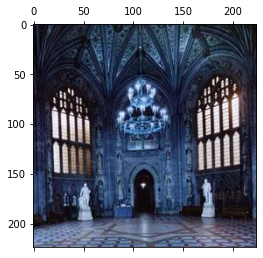

In [12]:
img = cv2.imread(r"output\test\church_inside\38291.jpg")
img = cv2.resize(img, (224, 224))

plt.matshow(img)

In [13]:
img = img / 255.0

In [14]:
y_pred = model.predict(np.array([img]))

In [15]:
scene = labels[np.argmax(y_pred.flatten())]
scene

'church_inside'